# Packages and Configurations

In [1]:
import astro_util, os, re
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath, physics}")
plt.rc("font", family="serif", serif=["Computer Modern"])
plt.rc("axes", titlesize=20, labelsize=18) 
plt.rc("figure", titlesize=20)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=10)

# Make Dark Frame FITS File

In [2]:
dark_data, dark_headers = astro_util.get_all_data_with_exposure(
    1 / 30, path="./data/unprocessed/dark/")

In [3]:
dark_name = os.listdir("./data/unprocessed/dark/")[0].split('_')
for (i, substr) in enumerate(dark_name):
    if bool(re.fullmatch("[0-9]+\.?[0-9]*s", substr)):
        dark_name[i] = str(len(dark_headers)) + 'x' + substr
    if bool(re.fullmatch("[0-9]+T[0-9]+\.fits", substr)):
        dark_name[i] = substr.split('T')[0] + ".fits"

In [7]:
fits.PrimaryHDU(data=np.array(np.median(dark_data, axis=0), dtype=np.uint16),
    header=astro_util.build_master_header(dark_headers[0], len(dark_headers))
    ).writeto("./data/" + '_'.join(dark_name), overwrite=True)

c:\Users\SLHHe\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [2]:
for filename in os.listdir("./data/"):
    for substr in filename.split('_'):
        if substr == "Dark":
            dark_master = fits.open("./data/" + filename)

In [9]:
bias_data, bias_headers = astro_util.get_all_data_with_exposure(
    0.01, path="./data/unprocessed/bias/")

In [10]:
bias_name = os.listdir("./data/unprocessed/bias/")[0].split('_')
for (i, substr) in enumerate(bias_name):
    if bool(re.fullmatch("[0-9]+\.?[0-9]*s", substr)):
        bias_name[i] = str(len(bias_headers)) + 'x' + substr
    if bool(re.fullmatch("[0-9]+T[0-9]+\.fits", substr)):
        bias_name[i] = substr.split('T')[0] + ".fits"

In [12]:
fits.PrimaryHDU(data=np.array(np.median(bias_data, axis=0), dtype=np.uint16),
    header=astro_util.build_master_header(bias_headers[0], len(bias_headers))
    ).writeto("./data/" + '_'.join(bias_name), overwrite=True)

c:\Users\SLHHe\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [3]:
for filename in os.listdir("./data/"):
    for substr in filename.split('_'):
        if substr == "Bias":
            bias_master = fits.open("./data/" + filename)

In [20]:
np.median(dark_master[0].data, axis=(-1, -2))

array([4., 0., 2.])

In [21]:
np.std(dark_master[0].data, axis=(-1, -2))

array([3.60267094, 0.89728451, 1.93275637])

In [33]:
hot_pixel = dark_master[0].data > [[[8]], [[1]], [[4]]]

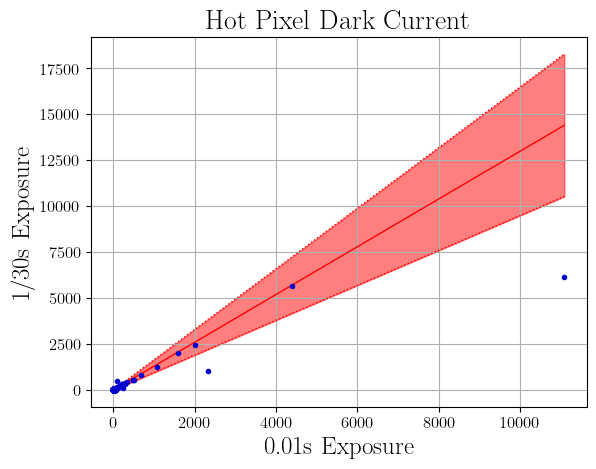

In [103]:
hot_pixel_bias = bias_master[0].data[hot_pixel]
hot_pixel_dark = dark_master[0].data[hot_pixel]
xline = [0, max(np.max(hot_pixel_bias), np.max(hot_pixel_dark))]
yline = [0, 1.3 * xline[1]]
yline_top = [0, 1.65 * xline[1]]
yline_bottom = [0, 0.95 * xline[1]]

plt.plot(xline, yline, lw=1, c="red")
plt.plot(xline, yline_top, lw=1, c="red", ls="dotted")
plt.plot(xline, yline_bottom, lw=1, c="red", ls="dotted")
plt.fill_between(xline, yline_bottom, yline_top,
                 color="red", alpha=0.5)

plt.plot(hot_pixel_bias, hot_pixel_dark, marker='o',
         ms=3, lw=0, color="mediumblue")

plt.xlabel("0.01s Exposure")
plt.ylabel("1/30s Exposure")
plt.title("Hot Pixel Dark Current")
plt.grid()

plt.savefig("fig/hotpix.png", bbox_inches="tight", dpi=300)
plt.show()

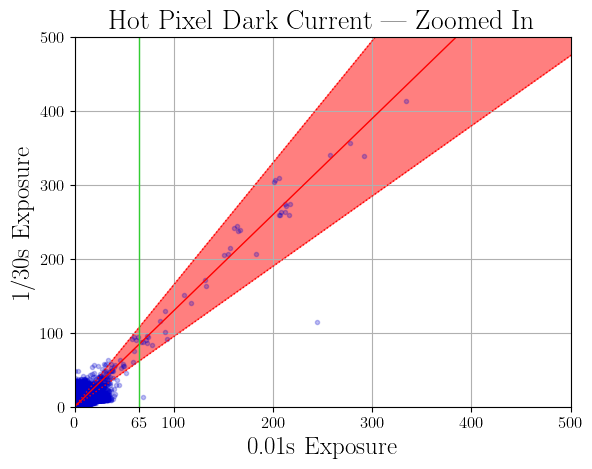

In [104]:
plt.plot(hot_pixel_bias, hot_pixel_dark, marker='o',
         ms=3, lw=0, color="mediumblue", alpha=0.25)

plt.plot(xline, yline, lw=1, c="red")
plt.plot(xline, yline_top, lw=1, c="red", ls="dotted")
plt.plot(xline, yline_bottom, lw=1, c="red", ls="dotted")
plt.fill_between(xline, yline_bottom, yline_top,
                 color="red", alpha=0.5)

plt.axvline(65, lw=1, c="limegreen")
plt.xticks([0, 65, 100, 200, 300, 400, 500])

plt.xlim(0, 500)
plt.ylim(0, 500)
plt.grid()

plt.xlabel("0.01s Exposure")
plt.ylabel("1/30s Exposure")
plt.title("Hot Pixel Dark Current --- Zoomed In")

plt.savefig("fig/hotpix-zoom.png", bbox_inches="tight", dpi=300)
plt.show()

In [4]:
dark_mask = ((bias_master[0].data > 65)
             & ((dark_master[0].data < 0.95 * bias_master[0].data)
                | (dark_master[0].data > 1.65 * bias_master[0].data)))
dark_master.close()
bias_master.close()

# Dark-Correct Image

In [5]:
for filename in os.listdir("./data/unprocessed/"):
    for substr in filename.split('_'):
        if substr == "Sun":
            sun_filename = filename
            sun_fits = fits.open("./data/unprocessed/" + filename)

In [15]:
dark_corrected_data = (sun_fits[0].data
    - dark_master[0].data.clip(None, sun_fits[0].data))

In [16]:
sun_header = astro_util.build_master_header(sun_fits[0].header, 1)
sun_header["OBSERVER"] = "SHAMLOO_YEGANEH_KHANALI"
sun_header["CALSTAT"] = 'D'

In [17]:
sun_filename = sun_filename.split('_')
sun_filename.pop(0)
sun_filename.insert(2, "DarkCorrected")
for name in reversed(["Shamloo", "Yeganeh", "Khanali"]):
    sun_filename.insert(0, name)
sun_filename[-2] = sun_filename[-2].split('T')[0]
sun_filename = '_'.join(sun_filename)

In [18]:
fits.PrimaryHDU(data=dark_corrected_data, header=sun_header
                ).writeto("./data/" + sun_filename, overwrite=True)

In [6]:
for filename in os.listdir("./data/"):
    for substr in filename.split('_'):
        if substr == "Sun":
            sun_fits = fits.open("./data/" + filename)

# Find Sun's Center and Radius

In [7]:
sun_rgb = sun_fits[0].data
dark_grayscale_mask = np.sum(dark_mask, axis=0) != 0
sun_grayscale = np.ma.array(astro_util.srgb_to_grayscale(sun_rgb),
                            mask=dark_grayscale_mask)
sun_grayscale_normalized = sun_grayscale / np.max(sun_grayscale)
sun_fits.close()

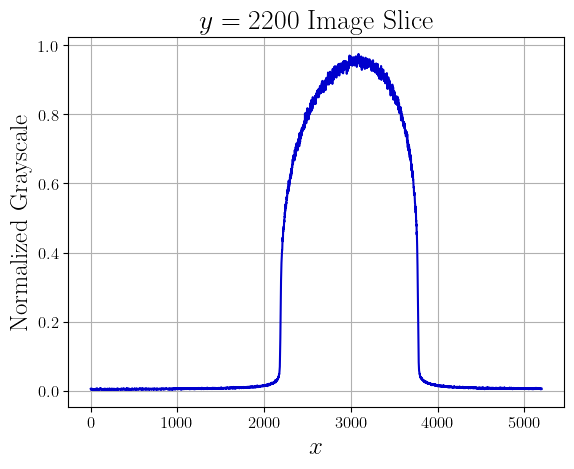

In [56]:
plt.title("$y=2200$ Image Slice")
plt.xlabel("$x$")
plt.ylabel("Normalized Grayscale")
plt.plot(sun_grayscale_normalized[2200, :], color="mediumblue")
plt.grid()
plt.savefig("fig/slice.pdf", bbox_inches="tight")
plt.show()

In [8]:
sun_pixels = np.argwhere(sun_grayscale_normalized > 0.15)

In [9]:
ymin_sun, xmin_sun = np.min(sun_pixels, axis=0)
ymax_sun, xmax_sun = np.max(sun_pixels, axis=0)
xdiameter, ydiameter = xmax_sun - xmin_sun, ymax_sun - ymin_sun
print(xmin_sun, xmax_sun)
print(ymin_sun, ymax_sun)
print(xdiameter, ydiameter)

2184 3782
1481 3079
1598 1598


In [10]:
radius = round((xdiameter + ydiameter) / 4)
geometric_center = (xmin_sun + radius, ymin_sun + radius)
print(radius)
print(geometric_center)

799
(2983, 2280)


In [54]:
uncropped_center_of_mass = astro_util.find_center_of_mass(
    sun_grayscale_normalized)
cropped_center_of_mass = astro_util.find_center_of_mass(
    sun_grayscale_normalized[ymin_sun:ymax_sun, xmin_sun:xmax_sun])
corrected_center_of_mass = (xmin_sun + cropped_center_of_mass[0],
                            ymin_sun + cropped_center_of_mass[1])
print(uncropped_center_of_mass)
print(corrected_center_of_mass)

4849963355.088673
1237294805.8409684
(2980.4115660847547, 2250.3285103827902)
(2996.5122615030214, 2280.4391110718807)


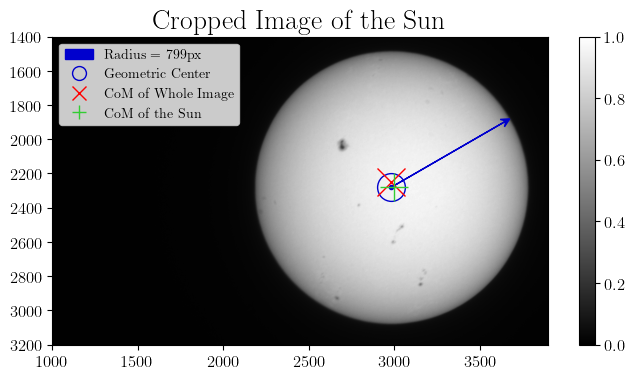

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))

im = plt.imshow(sun_grayscale_normalized, cmap="gray")
fig.colorbar(im)
ax.set_xlim(1000, 3900)
ax.set_ylim(3200, 1400)


ax.arrow(geometric_center[0], geometric_center[1],
         np.sqrt(3) / 2 * radius, -0.5 * radius, overhang=0.5,
         head_width=50, head_length=50, length_includes_head=True,
         color="mediumblue", label=f"Radius = {radius}px")
ax.plot([geometric_center[0]], [geometric_center[1]],
         marker='o', ms=3, c="mediumblue",)

ax.plot([geometric_center[0]], [geometric_center[1]], marker='o',
        ms=20, mfc="none", ls="none", c="mediumblue",
        label="Geometric Center")
ax.plot([uncropped_center_of_mass[0]], [uncropped_center_of_mass[1]],
        marker='x', ms=20, ls="none", c="red",
        label="CoM of Whole Image")
ax.plot([corrected_center_of_mass[0]], [corrected_center_of_mass[1]],
        marker='+', ms=20, ls="none", c="limegreen",
        label="CoM of the Sun")

ax.set_title("Cropped Image of the Sun")
ax.legend(loc="upper left", markerscale=0.5)

plt.savefig("fig/sun.pdf")
plt.show()

# Eddington Approximation

In [11]:
intensity = sun_grayscale_normalized[
    geometric_center[1], geometric_center[0] : geometric_center[0] + radius]

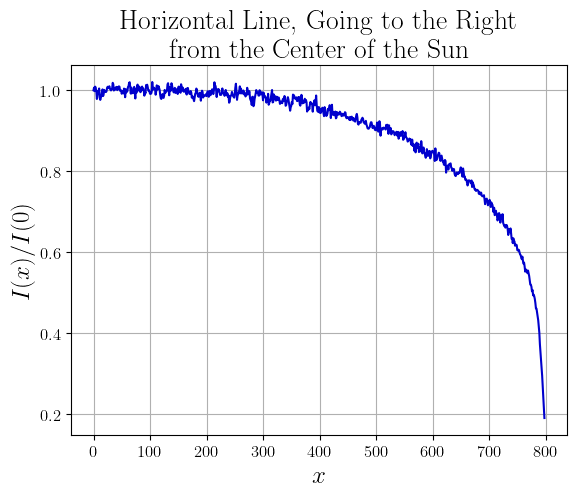

In [12]:
plt.title("Horizontal Line, Going to the Right\n"
          "from the Center of the Sun")
plt.xlabel("$x$")
plt.ylabel("$I(x) / I(0)$")
plt.plot(intensity / intensity[0], color="mediumblue")
plt.grid()
plt.savefig("fig/intensity.pdf", bbox_inches="tight")
plt.show()

In [13]:
x = np.linspace(0, radius, radius)
mu = np.sqrt(radius**2 - x**2) / radius

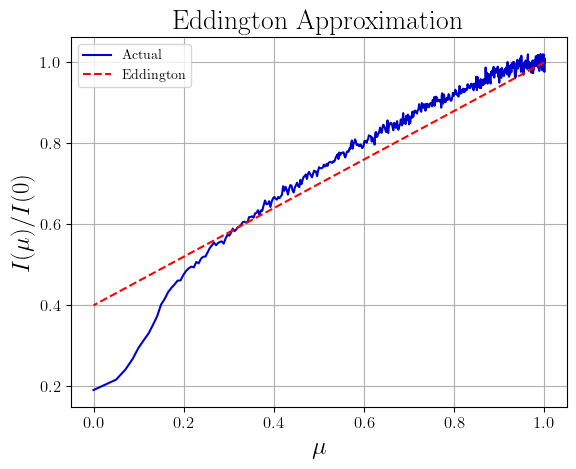

In [14]:
plt.title("Eddington Approximation")
plt.xlabel(r"$\mu$")
plt.ylabel(r"$I(\mu) / I(0)$")

plt.plot(mu, intensity / intensity[0],
         color="mediumblue", label="Actual")
plt.plot(mu, (2 + 3 * mu) / 5, color="red",
         ls="dashed", label="Eddington")

plt.grid()
plt.legend()

plt.savefig("fig/eddington.pdf", bbox_inches="tight")
plt.show()

In [136]:
r = 792
intensity = sun_grayscale_normalized[
    geometric_center[1], geometric_center[0] : geometric_center[0] + r]
x = np.linspace(0, r, r)
mu = np.sqrt(r**2 - x**2) / r

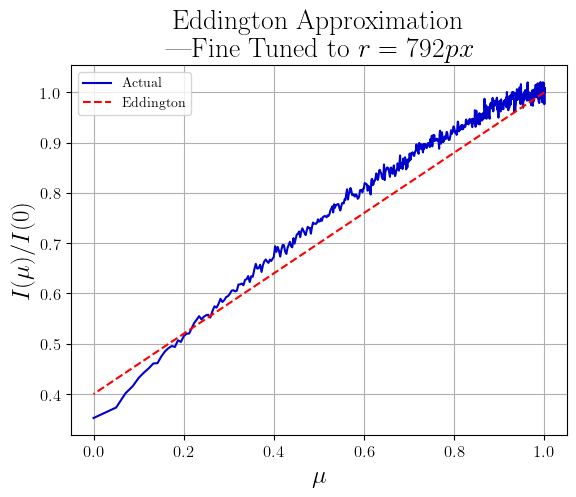

In [140]:
plt.title(f"Eddington Approximation\n"
          f"---Fine Tuned to $r={r}px$")
plt.xlabel(r"$\mu$")
plt.ylabel(r"$I(\mu) / I(0)$")

plt.plot(mu, intensity / intensity[0],
         color="mediumblue", label="Actual")
plt.plot(mu, (2 + 3 * mu) / 5, color="red",
         ls="dashed", label="Eddington")

plt.grid()
plt.legend()

plt.savefig("fig/eddington-modified.pdf", bbox_inches="tight")
plt.show()

# Sample Statistics

In [13]:
center_sample = sun_grayscale[
    geometric_center[1] - 50 : geometric_center[1] + 50,
    geometric_center[0] - 50 : geometric_center[0] + 50]
edge_sample = sun_grayscale[10:110,10:110]

print(f"Center:\tmean = {np.mean(center_sample)},"
      f"\tstd = {np.std(center_sample)}")
print(f"Dark Edge:\tmean = {np.mean(edge_sample)},"
      f"\tstd = {np.std(edge_sample)}")

Center:	mean = 10402.833287899999,	std = 100.94611424509759
Dark Edge:	mean = 43.614709,	std = 7.917673317844769


In [14]:
center_sample = sun_grayscale_normalized[
    geometric_center[1] - 50 : geometric_center[1] + 50,
    geometric_center[0] - 50 : geometric_center[0] + 50]
edge_sample = sun_grayscale_normalized[10:110,10:110]

print(f"Center:\tmean = {np.mean(center_sample)},"
      f"\tstd = {np.std(center_sample)}")
print(f"Dark Edge:\tmean = {np.mean(edge_sample)},"
      f"\tstd = {np.std(edge_sample)}")

Center:	mean = 0.9512969044670263,	std = 0.00923111265380294
Dark Edge:	mean = 0.0039883882123911045,	std = 0.0007240391064045766
